# E-commerce A/B Testing

An e-commerce company is testing a new web page design to see if it improves customer conversion rates(product purchases). We shall conduct an A/B test based on the provided data on user interactions with both the new and old pages. We'll analyze this data to help the company decide whether to adopt the new design or stick with the old one.

The data includes user IDs, timestamps, group assignments (new vs. old page), landing page types, and conversion outcomes. By digging into these details, we can obtain valuable insights to guide the company's decision-making and potentially boost their sales.

In [1]:
#Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import numba 

import warnings
warnings.filterwarnings('ignore')

# Setting seed
np.random.seed(33)

In [2]:
# Read data
df = pd.read_csv(r'ab_data.csv')
countries = pd.read_csv(r'countries.csv')

In [3]:
#A sample of the dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [4]:
#A sample of the dataset
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


# EDA of the Dataset


Checking for missing values is crucial for data reliability. Missing data can distort analyses and impact statistical validity. The code snippet assesses missing values in df and countries, facilitating data exploration.

In [5]:
# Check for missing values
print("Missing values:")
print(df.isna().sum())
print(countries.isna().sum())

Missing values:
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
user_id    0
country    0
dtype: int64


We shall also check for any data inconsistency in the dataset. Ideally the 'treatment' group should land on 'new_page' and the 'control' group on 'old_page'. 

In [6]:
# Check for data mismatches
df_mismatch = df[((df["group"] == "treatment") & (df["landing_page"] == "old_page")) |
                 ((df["group"] == "control") & (df["landing_page"] == "new_page"))]

n_mismatch = df_mismatch.shape[0]
percent_mismatch = round(n_mismatch / len(df) * 100, 2)

print(f'Number of mismatched rows: {n_mismatch} rows')
print(f'Percent of mismatched rows: {percent_mismatch} percent')

Number of mismatched rows: 3893 rows
Percent of mismatched rows: 1.32 percent


Given the low percentage, we can confidently omit these mismatched rows. This decision is further justified by the minimal impact on the overall data size. Retaining them would introduce inconsistencies that could skew our results and compromise the analysis.

While there's no universally accepted threshold for permissible mismatched data, it generally depends on the context and impact on the analysis. In this case, with a small percentage (1.32%) and potential for significant influence on results, omitting these rows aligns with best practices for ensuring data integrity and reliable analysis.

In [7]:
# Remove mismatched rows
df = df[((df["group"] == "treatment") & (df["landing_page"] == "new_page")) |
        ((df["group"] == "control") & (df["landing_page"] == "old_page"))]

Next we shall check if there any duplicates in the dataset and drop them.

In [8]:
# Check for duplicates
print("Number of duplicate user_id:", df.duplicated("user_id").sum())
print("Number of duplicate user_id:", countries.duplicated("user_id").sum())

Number of duplicate user_id: 2
Number of duplicate user_id: 1


In [9]:
# Drop duplicates
df = df.drop_duplicates("user_id")
countries = countries.drop_duplicates("user_id")

# Analysis

Before diving into the heart of A/B testing, we're establishing a baseline understanding of conversion rates across different scenarios. This provides a crucial context for interpreting the results of our subsequent analyses.

<b><i>Overall Conversion Rate:</i></b> We're calculating the overall conversion rate, representing the proportion of users who convert regardless of the page they land on. This gives us a general sense of the current conversion performance.

<b><i>Conversion Rates by Page:</i></b> We're also calculating conversion rates for both the old and new page designs. This allows us to compare their performance directly and identify any initial differences that might warrant further investigation.

In [10]:
print('Overall Conversion Rate is : ', df.converted.mean() * 100)
df.user_id = df.user_id.astype(str)
print('\nConversion Rates by Page is as follow: \n', df.groupby('group').mean() * 100)

Overall Conversion Rate is :  11.959667567149026

Conversion Rates by Page is as follow: 
            converted
group               
control    12.038630
treatment  11.880725


<b>Initial Insights:</b>

Our initial exploration reveals an overall conversion rate of 11.96%, highlighting that approximately 12 out of every 100 users convert. Drilling down further, we observe a slightly higher conversion rate for the control group (12.04%) compared to the treatment group (11.88%) using the old and new page designs, respectively. While the difference is small, it prompts further investigation in our A/B testing analysis to determine if this trend is statistically significant and whether the new page design truly impacts conversion rates.

# AB Test

We're employing a technique called bootstrap sampling to simulate various potential outcomes of the AB test. This involves repeatedly drawing random samples from the original dataset with replacement, effectively creating many alternate versions of the experiment. By comparing conversion rates across these simulated samples, we can gain a robust understanding of the variability in outcomes and assess the statistical significance of any observed differences.

In [11]:
# Statistical analysis
@numba.jit
def calculate_means_diff(df, size, n_iterations):
    means_diff = np.empty(n_iterations)
    for i in range(n_iterations):
        sample = df.sample(size, replace=True)
        means_diff[i] = sample[sample["group"] == "treatment"]["converted"].mean() - \
                        sample[sample["group"] == "control"]["converted"].mean()
    return means_diff

means_diff = calculate_means_diff(df, df.shape[0], 5000)

We're creating a histogram of the means_diff array to visualize the distribution of potential differences in conversion rates between the treatment and control groups, as simulated through bootstrap sampling.

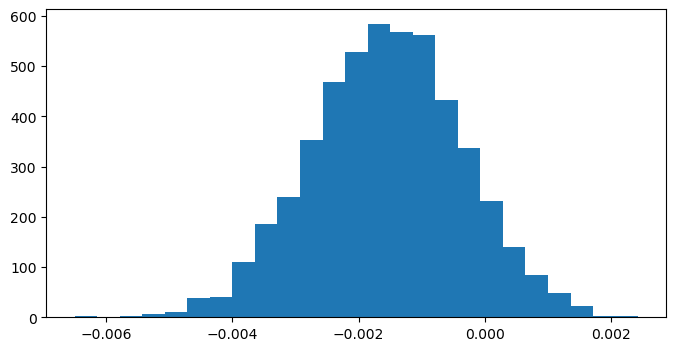

In [12]:
# Plot histograms
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(means_diff, bins=25)
plt.show()

<b>Hypothesis Testing</b>

We're conducting hypothesis testing to assess whether the observed difference in conversion rates between the treatment and control groups is statistically significant or merely due to chance.

<b><i>Null Hypothesis (H₀):</b></i>
There's no difference in conversion rates between the new and old page designs. Any observed difference is likely due to random variation.

<i><b>Alternative Hypothesis (H₁):</b></i>
The new page design does impact conversion rates, leading to a difference in conversion rates between the treatment and control groups.

In [13]:
# Hypothesis testing
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)
obs_diff = df[df["group"] == "treatment"]["converted"].mean() - df[df["group"] == "control"]["converted"].mean()

<b>Visualizing the Null Distribution and Observed Difference:</b>

We're creating a visual representation to compare the observed difference in conversion rates to the null distribution, aiding in hypothesis testing. By looking at where the red line falls, you can get a sense of how unusual it is compared to all the possible results. The further away from the center (0, where there's no difference), the less likely it is due to chance and the stronger the evidence for the new design having an effect.

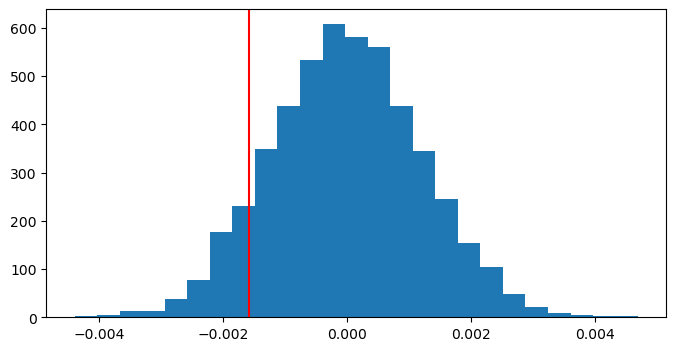

In [14]:
plt.figure(figsize=(8, 4), dpi=100)
plt.hist(null_vals, bins=25)
plt.axvline(obs_diff, c='red')
plt.show()

<b>Calculating the P-value for Statistical Significance:</b>

We're now quantifying the likelihood of observing the actual difference in conversion rates (or any more extreme difference) if the null hypothesis were true, using a metric called the p-value.

In [15]:
# Calculate p-value
p_value = (null_vals > obs_diff).mean()
print("p-value:", p_value)

p-value: 0.9028


<b>Interpreting the P-value:</b>

Based on the calculated p-value of 0.9028, it's difficult to conclude with strong statistical significance that the new page design has a meaningful impact on conversion rates.

Conventionally, a p-value below 0.05 is considered statistically significant, meaning we can reject the null hypothesis and infer that the observed difference is likely due to the new page design. In this case, the p-value of 0.9028 is high, suggesting there's a 90.28% chance of observing a similar or even larger difference in conversion rates by chance alone, even if the new design has no real effect.

# Chi - Square Test

The hypothesis testing(using null distribution and p-value) and the chi-square test offer valuable insights into the A/B testing results, but they do so in slightly different ways and provide complementary perspectives.

<b><i>Hypothesis Testing:</b></i> Focuses on difference in means and gives us probabilistic interpretation allowing us to reject the null hypothesis with certain level of confidence.

<i><b>Chi-Square Test:</b></i>

Analyzes overall association: This test evaluates whether the distribution of "converted" and "not converted" users is independent of the group they belong to (treatment or control).

Identifies dependence, not direction: A significant chi-square test indicates a relationship between the groups and conversion, but it doesn't tell us if the treatment group has a higher or lower conversion rate.

<i><b>Contingency Table:</b></i>

Visualizes the relationship: This table breaks down the conversion counts for each group, offering a clear picture of how conversions are distributed across the treatment and control conditions.

Provides more granular insights: By examining individual cells and comparing row/column proportions, we can gain deeper understanding of where potential differences or associations might lie.

In [16]:
# Chi-square test
def chi_square_test(data, group_column, variable):
    ct = pd.crosstab(data[group_column], data[variable])
    chi2, p, _, _ = chi2_contingency(ct)
    print(ct)
    return p

In [17]:
# Test for independence
p_value = chi_square_test(df, "group", "converted")
print('p-value:',p_value)
# interpret_results(p_value, "converted", "control", "treatment")

converted       0      1
group                   
control    127785  17489
treatment  128047  17264
p-value: 0.19158976298516003


While the hypothesis testing suggested a close call with a high p-value, the chi-square test adds another layer to the A/B testing analysis. With a p-value of 0.1916, we land in a somewhat inconclusive territory. 

A p-value of 0.1916 suggests that while there's a possibility of an association, it's not particularly strong. There's a 19.16% chance of observing a similar or even bigger association by chance alone, even if the new design has no real effect.

Taking both results together, we can't confidently claim a statistically significant impact of the new page design on conversion rates.

# Logistic Regression

Logistic regression is a powerful statistical tool that shines in A/B testing scenarios. It delves deeper than just comparing average conversion rates, providing richer insights into how different factors influence the probability of conversion. It accounts for individual user characteristics and predicts conversion probabilities for each user, not just an overall average.

The intercept in logistic regression captures the baseline probability of the outcome (conversion) when other predictors are zero. It represents the estimated conversion rate for users in the control group (ab_page = 0). Logistic regression relies on the intercept for accurate modeling, providing the starting point for predictions and allowing the interpretation of coefficient changes in other predictors, like ab_page, while holding other variables constant.

In [18]:
# Logistic regression
df["intercept"] = 1
df["ab_page"] = df.group.apply(lambda x: 1 if x == "treatment" else 0)

# Fit logistic regression model
model = sm.Logit(df['converted'], df[['intercept', 'ab_page']])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sat, 27 Jan 2024   Pseudo R-squ.:               8.085e-06
Time:                        22:32:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.

<b>Results</b>

The coefficient for the ab_page variable is negative (-0.0150), suggesting that being in the treatment group (new page design) might slightly decrease the probability of conversion, but this effect is not statistically significant (p-value = 0.190).

<i>Convergence:</i> The model fitting process converged successfully, indicating that reliable estimates were obtained.

<i>Pseudo R-squared:</i> This value is extremely low (8.085e-06), suggesting that the model doesn't capture much of the variability in conversion outcomes.

<i>Log-Likelihood Ratio Test:</i> The p-value (0.1897) is higher than the typical significance threshold (0.05), further supporting the lack of strong evidence for the new page design's effect.

# Further Steps

Expanding our scope, let's add the 'country' variable to the model. This will reveal if geographic factors play a role in conversion, potentially shedding light on user behavior across different regions.

In [19]:
# Merge with countries data
countries.user_id = countries.user_id.astype(str)
df = df.merge(countries, on="user_id", how="left")

Dummy variables ensure that each category is treated as a unique entity, preventing the model from assuming a natural order or hierarchy among them.
This inclusivity prevents potential biases and allows for a more accurate representation of the relationships between variables and the outcome.

In [20]:
# Create dummy variables
df = pd.get_dummies(df, columns=["country", "landing_page"], drop_first=True)

In [21]:
# Fit logistic regression model with additional variables
model = sm.Logit(df['converted'], df[['intercept', 'ab_page', 'country_UK', 'country_US']])
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Sat, 27 Jan 2024   Pseudo R-squ.:               2.324e-05
Time:                        22:32:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0150      0.

<b>Results</b>

The coefficient for ab_page is still negative (-0.0150) but not statistically significant (p-value = 0.191), suggesting a potential decrease in conversion probability for the new design, but we can't confidently conclude it has a meaningful impact.

<i>Convergence:</i> The model fitting process converged successfully, indicating reliable estimates.

<i>Pseudo R-squared:</i> Still extremely low (2.324e-05), suggesting the model explains very little of the variability in conversion outcomes.

<i>Log-Likelihood Ratio Test:</i> The p-value (0.1758) remains above the significance threshold, indicating a lack of strong evidence for the overall model's effectiveness in predicting conversion.

# Conclusion

This A/B testing analysis, employing various statistical techniques, has yielded an inconclusive verdict on the new page design's impact on conversion rates.

Both hypothesis testing and logistic regression models, with and without additional control variables, failed to provide statistically significant evidence that the new design leads to a systematic shift in conversion rates.

The chi-square test suggested a possibility of an association between the design and conversions, but the p-value was not low enough to draw a decisive conclusion.

Logistic regression analysis, even after incorporating 'country' as a factor, didn't reveal a meaningful impact of the new design, and the observed country effects lacked statistical significance.
Therefore, we cannot confidently recommend adopting the new page design based solely on the A/B testing results presented here.